# TP 2: Linear regression of Quentin BOURBON

In [ ]:
# Change here using YOUR own first and last names
fn1 = "quentin"
ln1 = "bourbon"
filename = "_".join(map(lambda s: s.strip().lower(),
                      ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
filename

'sd-tsia204_lab2_bourbon_quentin.ipynb'

In [ ]:
# Imports

import numpy as np
from numpy.linalg import inv
from numpy.linalg import svd 

import seaborn as sns
sns.set_theme()

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

from scipy import stats

from tqdm import tqdm

# 1. Preprocess the data

> (a) Set the random seed to 0.

> (b) Load the data. Print the mean, and standard deviation of every covariate. Is the data centered?
Normalized? Standardized?

> (c) Separate the data in train and test sets: save one fourth of the data as testing (you can use train_test_split from sklearn.model_selection) and standardize both the training and testing sets using the fit_transform and transform functions insklearn.preprocessing.StandardScaler.

> (d) Fit a regular OLS, do we need to fit the intercept?

> (e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model. This dataframe will be used along the TP to store and compare R2 coefficients of other variants of the OLS problem

In [ ]:
# Load the data
df = pd.read_csv('/content/meatspec.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


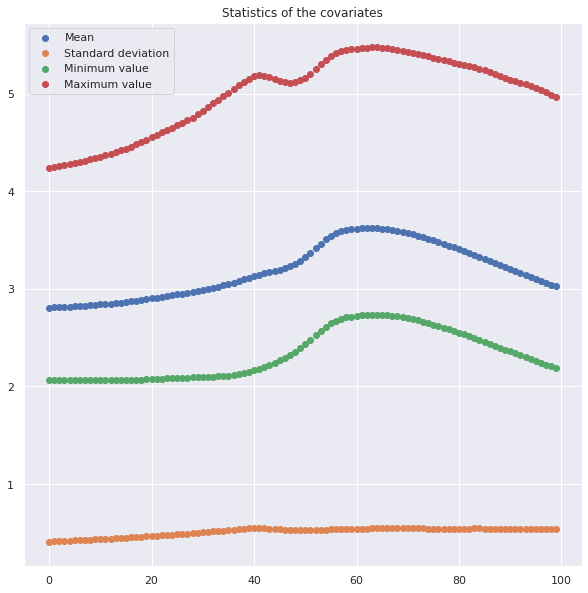

In [ ]:
y = df['fat'].values
X = df.drop(['fat'], axis=1)

# Statistics of the covariates
cov_mean, cov_std, cov_min, cov_max = X.mean(), X.std(), X.min(), X.max()

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(range(100), cov_mean, label='Mean')
ax.scatter(range(100), cov_std, label='Standard deviation')
ax.scatter(range(100), cov_min, label='Minimum value')
ax.scatter(range(100), cov_max, label='Maximum value')
ax.set_title("Statistics of the covariates")
ax.legend()
plt.show()

The data are not centered ($μ \neq 0$), normalized (min and max are not constant) nor standardized ($μ \neq 0$ and $σ \neq 1$).

When we stanrdadize the data we do not fit the testing set because we are not supposed to know it. However, we can approximate a standardization by doing the same transformation of the training set.

In [ ]:
# Set the random seed to 0
np.random.seed(0)

# Separate the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
n, p = X_train.shape

# Standardize both the training and testing sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # We do not fit for the testing set
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1)) # We do not fit for the testing set

After standardizing the data, the mean is null of X and y are equal to 0, and consequently the intercept is also equal to 0. So we do not need to fit the intercept.

In [ ]:
# Fit a regular OLS
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(f'R^2 = {reg.score(X_test, y_test)}')

R^2 = 0.9600547777973001


In [ ]:
# Create a dataframe storing the R2 score of all methods
df_coef = pd.DataFrame({'Method': [],
                        'R^2 score': []})
# Add a row to the dataframe
df_coef.loc[len(df_coef)] = ['OLS', reg.score(X_test, y_test)]
df_coef

,Method,R^2 score
0,OLS,0.960055


# 2. Forward variable selection

Program the method of the forward variable selection. You can use the test statistics of the test for nullity (as seen during the course). Do not define the stop criterion for the method, i.e. add a variables at each time until all the variables are used. Store the order of the variable selection and the associated p-value for each of them.

We will use the test of no effect to select covariates.

It consists in computing for each covariate $$T=\frac{\sqrt{n}|\hat{θ_n|}}{\hat{s_n}\hat{σ_n}}$$ and then chose the covariate with the bigger T. And its p-value is equal to $$p=2(1 - Φ(T))$$ where Φ is the cdf of the student law.

In [ ]:
def forward_variable_selection(X, y):
  
  # Initialization of the general variables
  n, p = X.shape
  r = y.copy()

  selected = [] 
  p_values = []
  remained = list(range(p))

  for i in range(p):
    
    # Initialization of the variables for an iteration
    pred = np.zeros((p, n, 1))
    T = np.zeros(p)

    for k in remained:

      # We compute the T value and store it and the prediction
      Xkones = np.stack((np.ones(n), X[:, k]), axis=1) # With the first column filled of ones
      Gram = Xkones.T @ Xkones / n 
      theta = LinearRegression(fit_intercept=False).fit(X[:, k:k+1], r).coef_ 
      pred[k] = X[:, k:k+1] @ theta.T 
      sigma = np.linalg.norm(r - pred[k]) ** 2 / (n - 2)
      s = np.sqrt(inv(Gram)[1, 1])
      t = (np.linalg.norm(theta) * np.sqrt(n)) / (sigma * s)
      T[k] = t

    # We search for the best variable and compute its p-value
    ind_best = np.argmax(T)
    p_value = 2 * (1 - stats.t.cdf(max(T), n - 2))

    # We update the general variables
    remained.remove(ind_best)
    selected.append(ind_best)
    p_values.append(p_value)
    r = r - pred[ind_best]

  return np.array(selected).flatten(), np.array(p_values).flatten()

selected, p_values = forward_variable_selection(X_train, y_train)

In [ ]:
selected, p_values

(array([40,  7, 39,  6, 41,  8, 38,  5, 42,  9, 37,  4, 36, 10, 97,  3, 43,
        11, 35,  2, 96, 12, 98, 13, 34,  1, 44,  0, 95, 14, 33, 15, 99, 16,
        32, 17, 94, 18, 93, 19, 45, 64, 31, 65, 92, 63, 91, 66, 90, 67, 30,
        20, 89, 62, 88, 68, 46, 61, 87, 69, 86, 60, 85, 53, 29, 52, 84, 70,
        83, 54, 28, 59, 82, 21, 47, 55, 81, 58, 27, 51, 80, 71, 26, 56, 79,
        57, 48, 72, 78, 50, 25, 22, 77, 73, 24, 74, 76, 75, 49, 23]),
 array([0.        , 0.0188045 , 0.01863951, 0.01771134, 0.01836415,
        0.01763391, 0.01847176, 0.01778875, 0.02171297, 0.02116435,
        0.02106814, 0.02070295, 0.02780258, 0.02715908, 0.03091214,
        0.03509105, 0.03225313, 0.03167833, 0.03581057, 0.03698073,
        0.04106149, 0.04477693, 0.04921862, 0.057652  , 0.05301899,
        0.05269649, 0.06527565, 0.06928292, 0.07334707, 0.08020132,
        0.07690551, 0.08449829, 0.09731746, 0.11732061, 0.12877312,
        0.14536732, 0.14988816, 0.18171641, 0.20631896, 0.24781526,
      

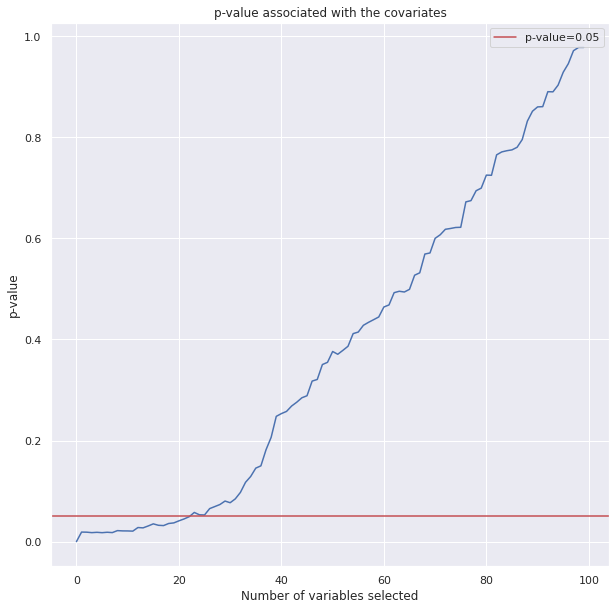

In [ ]:
# Plot the results of the forward variable selection
plt.figure(figsize=(10, 10))
plt.plot(p_values)
plt.axhline(0.05, c='r', label='p-value=0.05')
plt.xlabel('Number of variables selected')
plt.ylabel('p-value')
plt.title('p-value associated with the covariates')
plt.legend()
plt.show()

# 3. OLS on the selected variables

Run OLS on the variables with a p-value smaller than 0.05.
> (a) Apply the OLS of the sklearn library.

> (b) Store the R2 coefficient in df_coef

Since the list of selected covariates is sorted, it is enough to search for the first p-value > 0.05 to get all the covariates with p-value smaller than 0.05.

In [ ]:
# We firstly choose the variables by finding the index where the p-value is superior to 0.05
pstop = 0.05
ind = 0
while ind + 1 < len(p_values) and p_values[ind + 1] < pstop:
  ind += 1

# To check if we're good
print(p_values[ind])
print(p_values[ind+1])

# Print of some information
print(f'Number of variables selected = {ind + 1}')
print(f'Variable selected = {selected[:ind + 1]}')

0.04921861714864928
0.05765199552485156
Number of variables selected = 23
Variable selected = [40  7 39  6 41  8 38  5 42  9 37  4 36 10 97  3 43 11 35  2 96 12 98]


In [ ]:
# We can now create X with the selected variables
X_train_reduced = np.zeros((n, ind + 1))
X_test_reduced = np.zeros((X_test.shape[0], ind + 1))
for i, k in enumerate(selected[:ind + 1]):
  X_train_reduced[:, i] = X_train[:, k]
  X_test_reduced[:, i] = X_test[:, k]

# We now perform the OLS with that and store the R2
reg = LinearRegression(fit_intercept=False).fit(X_train_reduced, y_train)
df_coef.loc[len(df_coef)] = ['OLS with the selected variables', reg.score(X_test_reduced, y_test)]
df_coef

,Method,R^2 score
0,OLS,0.960055
1,OLS with the selected variables,0.955180


This is really near, so the variable selection is really accurate!

# 4. Using SequentialFeatureSelector

Using SequentialFeatureSelector on a linear regression estimator select (with forward selection), select the same number of variables as in the previous question.

> Elaborate on why the 2 algorithms do not return the same variables and store the R2 onto the corresponding dataFrame. 


In [ ]:
# Features selection with the library
sfs = SequentialFeatureSelector(LinearRegression(fit_intercept=False), n_features_to_select=ind+1) 
sfs.fit(X_train, y_train)
X_train_reduced = sfs.transform(X_train)
X_test_reduced = sfs.transform(X_test)

# To get wich covariates are selected
supp = sfs.get_support()
selected = np.array(range(p))[supp]

print(f'Number of variable selected = {X_train_reduced.shape[1]}')
print(f'Variables selected = {selected}')

# We now perform the OLS with that and store the R2
reg = LinearRegression(fit_intercept=False).fit(X_train_reduced, y_train)
df_coef.loc[len(df_coef)] = ['SequentialFeatureSelector', reg.score(X_test_reduced, y_test)]
df_coef

Number of variable selected = 23
Variables selected = [ 0  1  3 18 19 21 34 35 39 40 43 46 47 48 49 57 72 74 82 87 90 97 99]


,Method,R^2 score
0,OLS,0.960055
1,OLS with the selected variables,0.955180
2,SequentialFeatureSelector,0.938730


The two algorithms do not return the same covariates because the criterion of the selection is not the same. 

In the course, we search for the best covariate in the sense of the p-value.

However, when we look at the doc of SequentialFeatureSelector we see that it chooses the best features based on the cross-validation score of an estimator.

# 5 Ridge

Code your own ridge estimator using expression derived in class. Test it for a penalty parameter α spaced evenly on a log scale 10e-9 to 10e2.

> (a) Plot how the values of the coefficients change with α.

>(b) Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

>(c) For the best performing value of α (the one with smallest training error) store the R2 results

The solution of finding the argmin of $$||y-Xθ||^2+nα||θ||^2$$ is $$\hat{θ} = (X^TX+n\alpha I)^{-1}X^Ty$$

We have to be cautious with implemenations of ridge on libraries because it searchs the argmin of $$||y-Xθ||^2+α||θ||^2$$ which admits as solution $$\hat{θ} = (X^TX+\alpha I)^{-1}X^Ty$$. So there are a factor n between the penality in the course and the penality in libraries.

In [ ]:
def ridge_estimator(X, y, alpha):
  '''
  Compute the ridge estimator as we have seen in class
  '''
  n, p = X.shape
  return inv(X.T @ X + n * alpha * np.eye(p)) @ X.T @ y

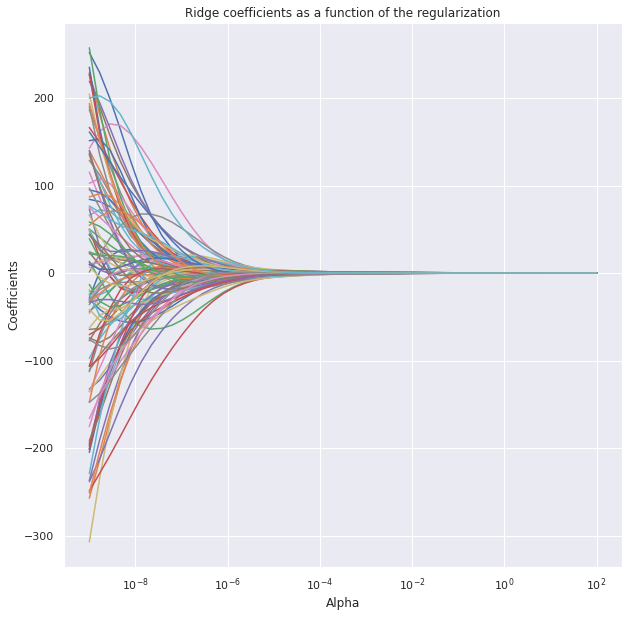

In [ ]:
alphas = np.logspace(-9, 2)
thetas = np.zeros((len(alphas), X_train.shape[1]))

for i, alpha in enumerate(alphas):
  thetas[i] = ridge_estimator(X_train, y_train, alpha).reshape(p, )

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(alphas, thetas)
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('Coefficients')
ax.set_title('Ridge coefficients as a function of the regularization')
plt.show()

For alpha large, 0 is the solution, which is normal because it become equivalent to find the argmin of $$nλ||θ||^2$$

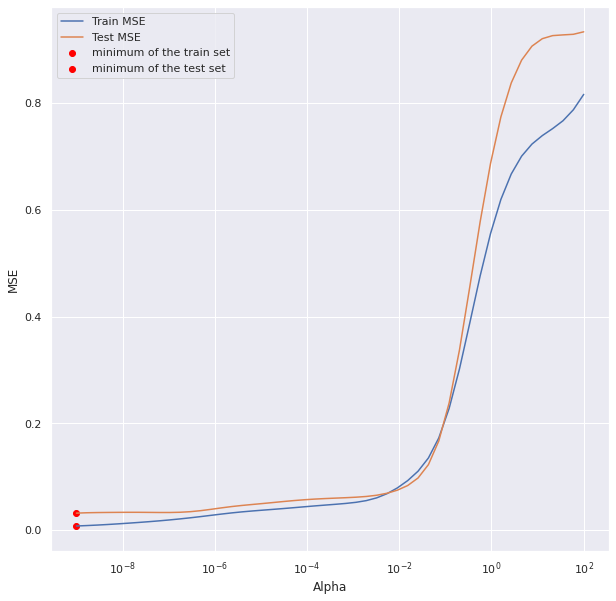

In [ ]:
train_mse = np.zeros(len(alphas))
test_mse = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
  train_mse[i] = mean_squared_error(y_train, X_train @ thetas[i])
  test_mse[i] = mean_squared_error(y_test, X_test @ thetas[i])

# Plot 
plt.figure(figsize=(10, 10))
plt.plot(alphas, train_mse, label='Train MSE')
plt.plot(alphas, test_mse, label='Test MSE')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.scatter(alphas[np.argmin(train_mse)], np.min(train_mse), marker='o', color='red', label='minimum of the train set')
plt.scatter(alphas[np.argmin(test_mse)], np.min(test_mse), marker='o', color='red', label='minimum of the test set')
plt.legend()
plt.show()

In [ ]:
df_coef.loc[len(df_coef)] = ['Ridge', r2_score(y_test, X_test @ thetas[np.argmin(test_mse)])]
df_coef

,Method,R^2 score
0,OLS,0.960055
1,OLS with the selected variables,0.955180
2,SequentialFeatureSelector,0.938730
3,Ridge,0.968269


# 6. Lasso 

Use the sklearn version of the Lasso. Test it for a penalty parameter α spaced evenly on a log scale
10e-5 to 10e-2.

> (a) To avoid having warnings and error you want to decrease the parameter tol or increase max_iter. Elaborate on why these warning arise and on the solution.

> (b) Plot the number of coefficients that are different from 0 for each value of α.

> (c) Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

> (d) For the best performing value of α on the test set store the R2 results.


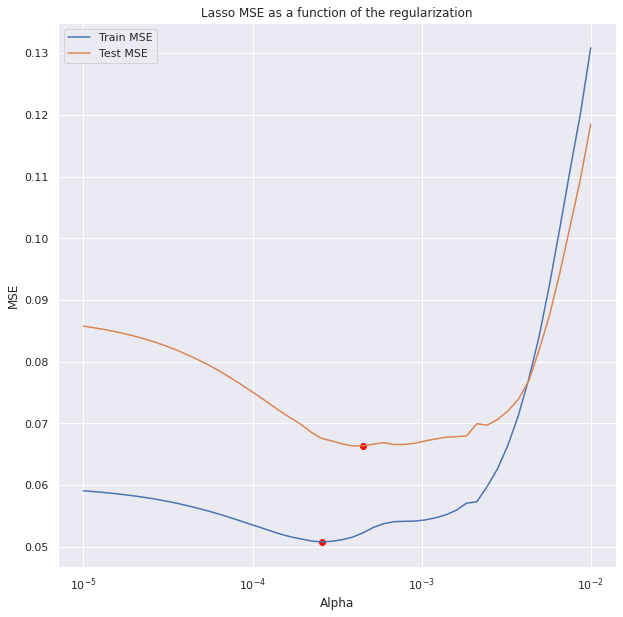

In [ ]:
# We initiliaze the variables
alphas = np.logspace(-5, -2)
train_mse = np.zeros(len(alphas))
test_mse = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):

  # We perform the lasso and compute the prediction
  lasso = Lasso(alpha=alpha, max_iter=50000, tol=0.03).fit(X_train, y_train)
  y_train_pred = lasso.predict(X_train)
  y_test_pred = lasso.predict(X_test)

  # We store the mean squared error
  train_mse[i] = mean_squared_error(y_train, y_train_pred)
  test_mse[i] = mean_squared_error(y_test, y_test_pred)

# We plot the mean squared error as a function of alpha
plt.figure(figsize=(10, 10))
plt.plot(alphas, train_mse, label='Train MSE')
plt.plot(alphas, test_mse, label='Test MSE')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso MSE as a function of the regularization')
plt.scatter(alphas[np.argmin(train_mse)],np.min(train_mse),marker='o',color='red')
plt.scatter(alphas[np.argmin(test_mse)],np.min(test_mse),marker='o',color='red')
plt.legend()
plt.show()

Because of the norm 1, we get easily problems of convergence.

When the tolerance is too small and the learning step too big, the descent algorithm canno't converge because it switches consecutively on the left and then on the right of the optimal point. Thus, if we rise the tolerance then we are less accurate but it enables the algorithm to converge.

And sometimes it only needs more iterations because the convergence is too slow, hence the use of rising the number of iterations. 

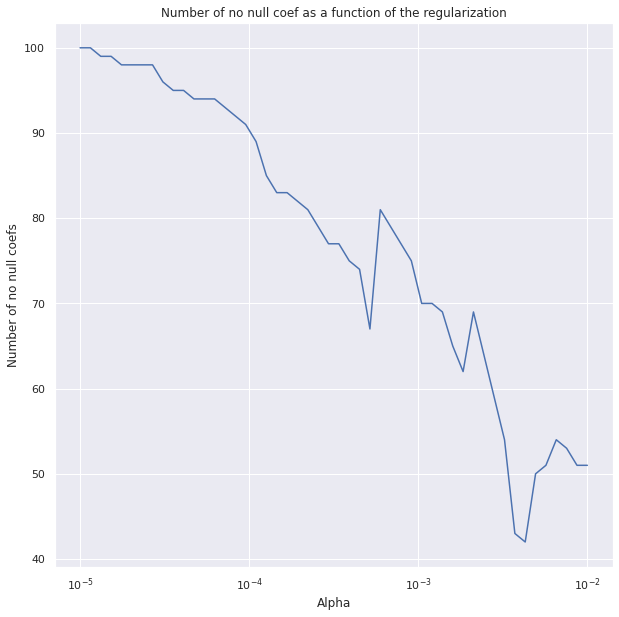

In [ ]:
# Computing the number of null coefficient as a function of alpha
nb_no_null_coef = np.zeros(len(alphas))
for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha, max_iter=50000, tol=0.03).fit(X_train, y_train)
    theta = lasso.coef_
    nb_no_null_coef[i] = len(theta[np.abs(theta) > 1e-8]) # Here we apply a thresh to consider if a coef is null or not

# Plot
plt.figure(figsize=(10, 10))
plt.plot(alphas, nb_no_null_coef)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Number of no null coefs')
plt.title('Number of no null coef as a function of the regularization')
plt.show()

When α is large, the problem becomes the minimization of $||θ||$ that admits $θ=0$ as a solution. It explains why we find more null coefficients when α rises.

In [ ]:
alpha_opt = alphas[np.argmin(train_mse)] # best alpha
# We perform the lasso with the best penalty
lasso = Lasso(alpha=alpha_opt, max_iter=50000, tol=0.03).fit(X_train, y_train)
df_coef.loc[len(df_coef)] = ['Lasso', lasso.score(X_test, y_test)]
df_coef

,Method,R^2 score
0,OLS,0.960055
1,OLS with the selected variables,0.955180
2,SequentialFeatureSelector,0.938730
3,Ridge,0.968269
4,Lasso,0.932695


# 7. Cross-validation

Code your own version of the crossvalidation. Preferable, in the same way as sklearn’s version, the length of every pair of folds should differ at most by one. Use the sklearn version of the Elastic net. Validate with a cross-validation that you implement. Test it for a penalty parameter α-ridge
spaced evenly on a log scale 10e-10 to 10e3 and α-lasso in [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99].

ElasticNet minimizes $||y-Xθ||^2_2+2αnl_1||θ||_1+αn(1-l_1)||θ||_2^2$.

Simply said it minimizes $||y-Xθ||^2_2+2na||θ||_1+nb||θ||_2^2$ with $α = a + b$ and $l_1 = \frac{a}{a+b}$.

With the notations of the course we deduce: $2na = 2α_L$ and $nb = nα_R$. So $a=\frac{α_L}{n}$ and $b = α_R$.

In [ ]:
def cross_val_score(estimator, X, y, nb_folds=5):
  '''
  Compute the cross validation scores
  '''
  n = len(y)
  fold_size = n // nb_folds
  nb_remained = n % nb_folds # Number of samples that we have to distribute after fold_size
  start_ind = 0
  scores = []
  
  for i in range(nb_folds):

    # We search for the length of the test size
    if nb_remained > 0:
      i_fold_size = fold_size + 1
      nb_remained -= 1

    else:
      i_fold_size = fold_size

    # We create the trainint and testing set 
    end_ind = start_ind + i_fold_size
    X_test = X[start_ind:end_ind]
    y_test = y[start_ind:end_ind]
    X_train = np.concatenate((X[:start_ind], X[end_ind:]))
    y_train = np.concatenate((y[:start_ind], y[end_ind:]))

    # We compute the r2 after fitting the model
    r2 = estimator.fit(X_train, y_train).score(X_test, y_test)
    scores.append(r2)
    start_ind = end_ind

  return np.asarray(scores)
  
print(f'Result of cross validation with 5 folds: {cross_val_score(Lasso(alpha=alpha_opt, max_iter=15000, tol=0.04), X_train, y_train)}')

Result of cross validation with 5 folds: [0.90384354 0.92622557 0.97129079 0.86841692 0.93981244]


In [ ]:
# We will test for these values of alpha
alphas_r = np.logspace(-10, 3)
alphas_l = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]

# We wil store the best score with the best parameters
best_alpha_r = None
best_alpha_l = None
best_score = 0

for alpha_l in tqdm(alphas_l):
  for alpha_r in alphas_r:

    a = alpha_l / n
    b = alpha_r
    l1 = a / (a + b)
    alpha = a + b
    score = (cross_val_score(ElasticNet(fit_intercept=False, alpha=alpha, l1_ratio=l1, max_iter=15000, tol=0.04), X_train, y_train) ** 2).mean()

    if score > best_score:
      
      best_score = score
      best_alpha_r = alpha_r
      best_alpha_l = alpha_l

print(f'Le meilleur alpha-ridge est {best_alpha_r}')
print(f'Le meilleur alpha-lasso est {best_alpha_l}')

100%|██████████| 6/6 [00:38<00:00,  6.39s/it]

Le meilleur alpha-ridge est 0.0007906043210907702
Le meilleur alpha-lasso est 0.1


However, I think you did a mistake in your question and you meant to search the best alpha spacede evenly on a log scale 10e-10 to 10e3 and l1_ratio in [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]. That seems more logical.

In [ ]:
# We will test for these values of alpha
alphas = np.logspace(-10, 3)
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]

# We wil store the best score with the best parameters
best_alpha = None
best_l1_ratio = None
best_score = 0

for alpha in tqdm(alphas):
  for l1_ratio in l1_ratios:

    # We compute the mean score
    score = cross_val_score(ElasticNet(fit_intercept=False, alpha=alpha, l1_ratio=l1_ratio, max_iter=15000, tol=0.04), X_train, y_train).mean()

    if score > best_score:
      best_score = score
      best_alpha = alpha
      best_l1_ratio = l1_ratio

print(f'Le meilleur alpha est {best_alpha}')
print(f'Le meilleur l1_ratio est {best_l1_ratio}')

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Le meilleur alpha est 0.0007906043210907702
Le meilleur l1_ratio est 0.1


In [ ]:
# We compute the score with these values of alpha and l1_ratio
score = ElasticNet(fit_intercept=False, alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=15000, tol=0.04).fit(X_train, y_train).score(X_test, y_test)
df_coef.loc[len(df_coef)] = ['Crossvalidation and ElasticNet', score]
df_coef

,Method,R^2 score
0,OLS,0.960055
1,OLS with the selected variables,0.955180
2,SequentialFeatureSelector,0.938730
3,Ridge,0.968269
4,Lasso,0.932695
5,Crossvalidation and ElasticNet,0.939526


# 8. Bootstrap

For this question, we are going to use only variable 40 of the dataset original (non-centered) X. Plot the dataset and the regression line fitted with the whole sample. Generate 50 bootstrap samples, for each of the samples fit a regression model and plot the 50 estimated regression lines in the same
plot (by setting alpha=.4 in the plotting function you can make the lines more transparent for the sake of readability of the plot). Finally, in the same plot, plot the prediction intervals (see exercise 12 in the lecture notes for the expression of the confidence intervals for the one dimensional case).


For the one dimensional case, we have (result from the first lab):
$$PI(x) = \textit{pred(x)} + t^{n-1}_{1-α/2}\hat{σ}\sqrt{1+ \frac{1}{n}+\frac{(x-\bar{x})^2}{\sum (x_i - \bar{x})^2}}$$

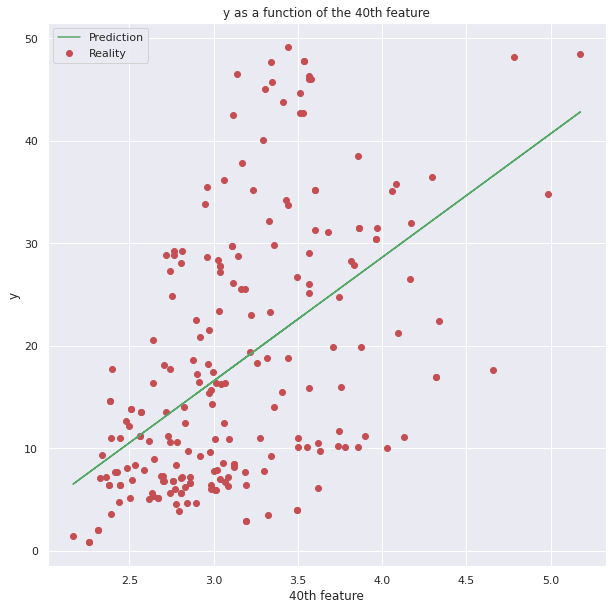

In [ ]:
# We create X only the 40th feature non-centered 
n = len(y)
X_reduced = X.to_numpy()[:, 40].reshape(n)

# We fit the ols
reg = LinearRegression().fit(X_reduced.reshape(-1, 1), y)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced, y, color='r', label='Reality')
plt.xlabel('40th feature')
plt.ylabel('y')
plt.plot(X_reduced, reg.predict(X_reduced.reshape(-1, 1)), color='g', label='Prediction')
plt.legend()
plt.title(f'y as a function of the {40}th feature')
plt.show()

In [ ]:
def bootstrap_dataset(X, y, N):
  # Create N bootstrap datasets
  n = X.shape[0]
  X_bootstrap = np.empty((N, n, p))
  y_bootstrap = np.empty((N, n))
  for j in range(N):
    for k in range(n):
      i = np.random.randint(n) # Sample chosen
      X_bootstrap[j, k] = X[i]
      y_bootstrap[j, k] = y[i]
  return X_bootstrap, y_bootstrap

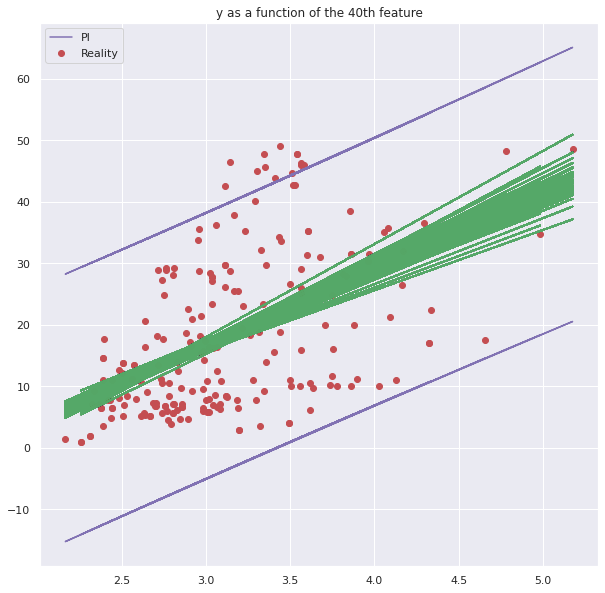

In [ ]:
X_bootstrap, y_bootstrap = bootstrap_dataset(X_reduced, y, 50)

# Plot the real 
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced, y, color='r', label='Reality')
plt.title(f'y as a function of the 40th feature')

# OLS with all the samples
ols = LinearRegression().fit(X_reduced.reshape(-1, 1), y)

# Computing of the PI
pred = ols.predict(X_reduced.reshape(-1, 1))
std2 = np.sum((y - pred)**2) / (n - 2)
alpha = 0.05 # Confidence of the interval
quantile = stats.t.ppf(1-alpha/2, n-2)

min_PI = pred - quantile * np.sqrt(std2 * (1 + 1/n + (X_reduced - np.mean(X_reduced))**2 / np.sum((X_reduced - np.mean(X_reduced))**2)))
max_PI = pred + quantile * np.sqrt(std2 * (1 + 1/n + (X_reduced - np.mean(X_reduced))**2 / np.sum((X_reduced - np.mean(X_reduced))**2)))

# Plot of the PI
plt.plot(X_reduced, min_PI, c='m', label='PI')
plt.plot(X_reduced, max_PI, c='m')

# Computing of the OLS on bootstrap samples
for i in range(50):
  pred = LinearRegression().fit(X_bootstrap[i], y_bootstrap[i]).predict(X_bootstrap[i])
  plt.plot(X_bootstrap[i], pred, alpha=0.4, c='g')

plt.legend()
plt.show()

# 9. PCA
Compute the covariance matrix. Compute the singular value decomposition of the covariance matrix. For consistency in the notation use $U, s, V = SVD(X^TX)$

>(a) Plot a heatmap of the covariance matrix.

>(b) In PCA we transform the data to a new coordinate system such that the greatest variance by some scalar projection of the data lies on the first coordinate (called the first principal component, PC1), the second greatest variance in the second PC and so on. The PCs are computed given the above SVD, as XU. Instead of using the whole transformation, XU

> (c) Plot the amount of variance explained by the first k components for k P 2..p.

> (d) We will use (as an approximation) the first 2 PCs. Plot the projected data using as color the value of y and interpret the plot.

> (e) Run OLS on the projected data using k components for k evenly spaced in 2..p. Store the best score in the dataFrame.


Thanks to SVD, we have $X^T X = UsV^T$. Since $X^TX$ is symetric we have $U=V$ (spectral theorem). The principal components are the projection of X on the eigenvectors of $X^T X$. Then it is given by $XV = XU$.

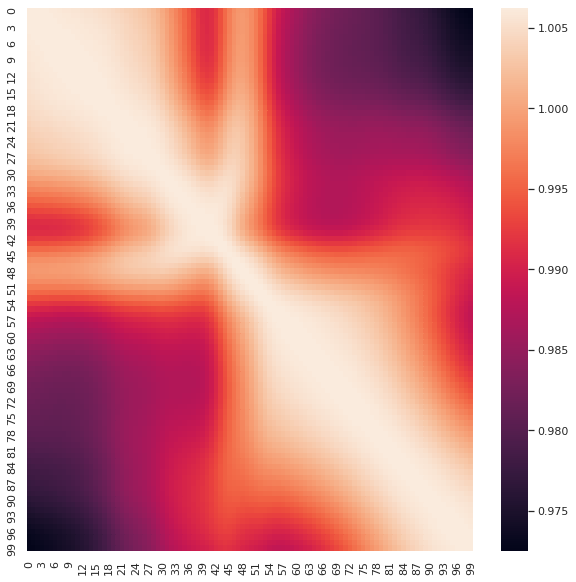

In [ ]:
n = len(y_train)
# Because X_train is centered , the covariance matrix is
cov = X_train.T @ X_train / (n - 1)
# We perform the SVD on the covariance matrix.
U, s, Vt = svd(cov)

plt.figure(figsize=(10, 10))
sns.heatmap(cov)
plt.show()

There is a big correlation between the covariates.

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

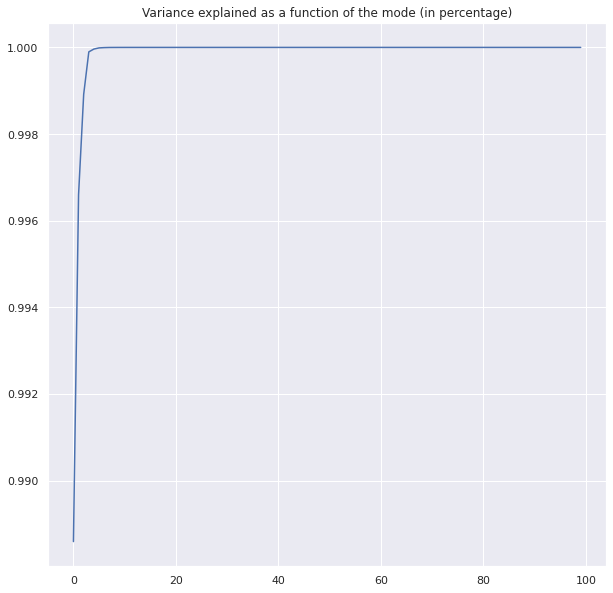

In [ ]:
variance_explained = []
for k in range(p):
  variance_explained.append(np.sum(s[:k+1]))

# We divise by the total variance to get the percentage
variance_explained /= np.sum(s)

plt.figure(figsize=(10, 10))
plt.plot(range(p), variance_explained)
plt.title('Variance explained as a function of the mode (in percentage)')
plt.show()


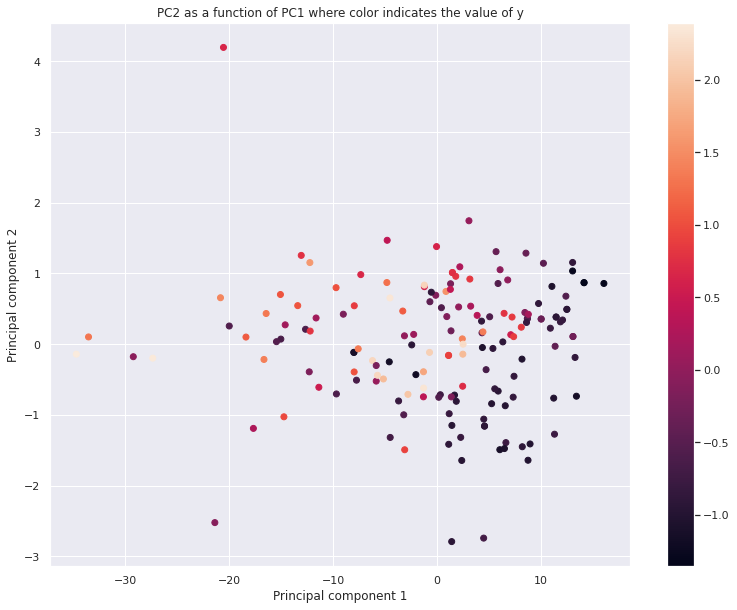

In [ ]:
# Computing principal components
PC1 = X_train @ U[:, 0]
PC2 = X_train @ U[:, 1]

# Plot PC2 as a function of PC1
plt.figure(figsize=(13, 10))
plt.title('PC2 as a function of PC1 where color indicates the value of y')
plt.scatter(PC1, PC2, c=y_train)
plt.ylabel('Principal component 2')
plt.xlabel('Principal component 1')
plt.colorbar()
plt.show()

We see that we can a bit separate y value by clustering this graph

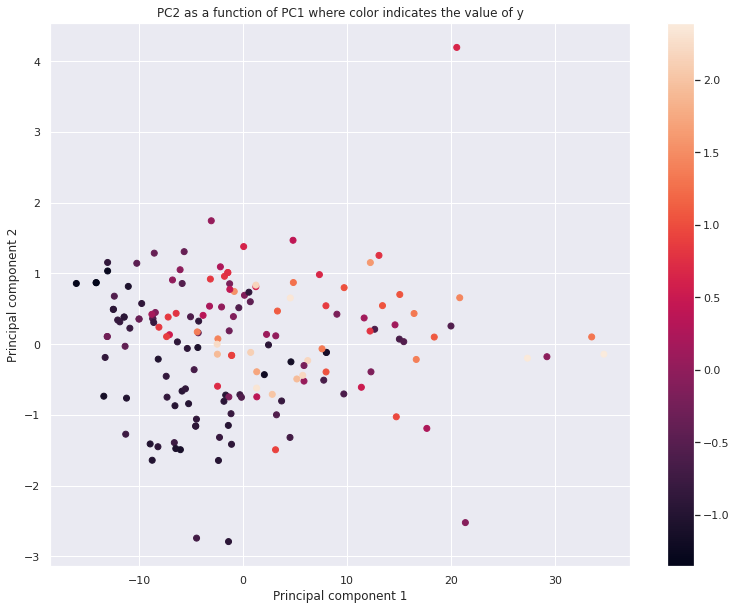

In [ ]:
# We now use the implementation of PCA of sklearn
pca = PCA(n_components=2)
X_projected = pca.fit_transform(X_train)
plt.figure(figsize=(13, 10))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y_train)
plt.ylabel('Principal component 2')
plt.xlabel('Principal component 1')
plt.title('PC2 as a function of PC1 where color indicates the value of y')
plt.colorbar()
plt.show()

It's symetric. That is not a problem, because if u is an eigenvector -u is also an eigenvector.

Le meilleur score est obtenu avec 82 composantes principales


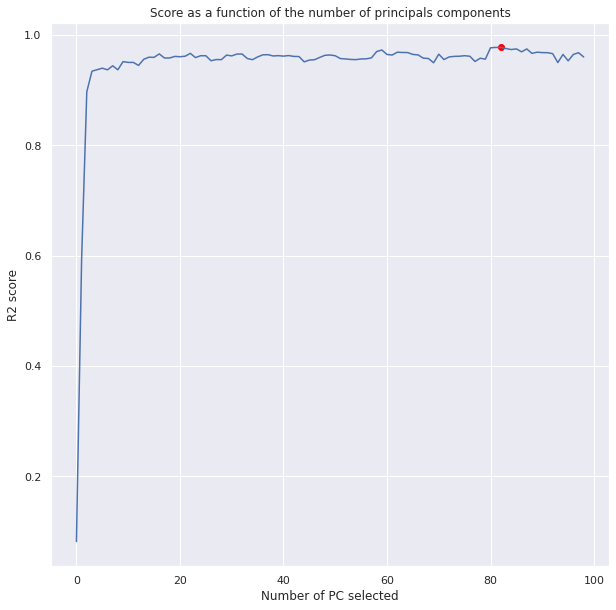

,Method,R^2 score
0,OLS,0.960055
1,OLS with the selected variables,0.955180
2,SequentialFeatureSelector,0.938730
3,Ridge,0.968269
4,Lasso,0.932695
5,Crossvalidation and ElasticNet,0.939526
6,OLS with PCA,0.977460


In [ ]:
# We now run PCA with k components
results = []
for k in range(2, p+1):
  X_train_projected = X_train @ U[:, :k]
  X_test_projected = X_test @ U[:, :k]

  reg = LinearRegression(fit_intercept=False).fit(X_train_projected, y_train)

  score = reg.score(X_test_projected, y_test)
  
  results.append(score)

results = np.asarray(results)
print(f'Le meilleur score est obtenu avec {results.argmax()} composantes principales')
plt.figure(figsize=(10, 10))
plt.plot(range(p-1), results)
plt.scatter(results.argmax(), results.max(),marker='o',color='red')
plt.title('Score as a function of the number of principals components')
plt.xlabel('Number of PC selected')
plt.ylabel('R2 score')
plt.show()
df_coef.loc[len(df_coef)] = ['OLS with PCA', results.max()]
df_coef

# 10. Summarize

Summarize the results of the models and elaborate in their main characteristics.

All the methods present good scores.

Lasso is good when a few number of covariates are linked with the target.

At the contrary, Ridge is good when a lot number of covariates are linked with the target but this is really sensitive to outliers.

In this case, Ridge is better than Lasso which means that a lot of covariates are useful to understand the target.

We also test 3 differents methods to reduce the number of covariates without reducing the score too much. PCA is one of the best before our own Feature Selection.

With the cross-validation we avoid the overfitting, and elasticnet enables to apply great l1 and l2 penalties so that we got a good score.